In [1]:
dir0 =  '/home/cloudera/2.kkbox_churn/data01/big_table_01/'
infile = dir0 + 'has_expired/19a.train_set'

In [2]:
df0 = spark.read.format('parquet').load(infile)
df0.count()

42647

In [3]:
# count null values

from pyspark.sql.functions import col

for c in df0.columns:
    cnt_na = df0.where(col(c).isNull()).count()
    print(c, ':', cnt_na)

msno : 0
city : 0
age : 17016
gender : 17286
registered_via : 0
days_since_init_regist : 0
init_date : 0
final_date : 0
gaps_count : 0
total_gap_len : 0
has_long_gap : 0
has_expired : 0
last_pay_method : 0
last_plan_days : 0
last_list_price : 0
last_actual_paid : 0
last_discount : 0
last_paid_per_day : 0
actual_paid_cnt_uniq : 0
actual_paid_mode : 0
auto_renew_cnt_uniq : 0
auto_renew_mode : 0
discount_cnt_uniq : 0
discount_mode : 0
list_price_cnt_uniq : 0
list_price_mode : 0
pay_method_cnt_uniq : 0
pay_method_mode : 0
plan_days_cnt_uniq : 0
plan_days_mode : 0
actual_paid_sum : 0
actual_paid_per_sub_day : 0
discount_sum : 0
discount_per_sub_day : 0
list_price_sum : 0
list_price_per_sub_day : 0
last12WeekOnLine : 0
w12_M25 : 0
w12_M50 : 0
w12_M75 : 0
w12_M985 : 0
w12_M100 : 0
w12_Munq : 0
w12_Msecs : 0
w12_Mtotal : 0
w12_M25_D_Mtotal : 19
w12_M50_D_Mtotal : 19
w12_M75_D_Mtotal : 19
w12_M985_D_Mtotal : 19
w12_M100_D_Mtotal : 19
w12_Munq_D_Mtotal : 19
w12_M25M50M75_D_Mtotal : 19
w12_M985M1

# find numeric/categorical fields

In [4]:
field_types = df0.dtypes
field_types

[('msno', 'string'),
 ('city', 'string'),
 ('age', 'int'),
 ('gender', 'string'),
 ('registered_via', 'string'),
 ('days_since_init_regist', 'int'),
 ('init_date', 'string'),
 ('final_date', 'string'),
 ('gaps_count', 'int'),
 ('total_gap_len', 'int'),
 ('has_long_gap', 'boolean'),
 ('has_expired', 'boolean'),
 ('last_pay_method', 'string'),
 ('last_plan_days', 'int'),
 ('last_list_price', 'int'),
 ('last_actual_paid', 'int'),
 ('last_discount', 'int'),
 ('last_paid_per_day', 'double'),
 ('actual_paid_cnt_uniq', 'int'),
 ('actual_paid_mode', 'int'),
 ('auto_renew_cnt_uniq', 'int'),
 ('auto_renew_mode', 'boolean'),
 ('discount_cnt_uniq', 'int'),
 ('discount_mode', 'int'),
 ('list_price_cnt_uniq', 'int'),
 ('list_price_mode', 'int'),
 ('pay_method_cnt_uniq', 'int'),
 ('pay_method_mode', 'string'),
 ('plan_days_cnt_uniq', 'int'),
 ('plan_days_mode', 'int'),
 ('actual_paid_sum', 'int'),
 ('actual_paid_per_sub_day', 'double'),
 ('discount_sum', 'int'),
 ('discount_per_sub_day', 'double'),
 

In [5]:
numeric_cols = [field_type[0]  for field_type in field_types  if field_type[1] in ['int', 'double']]
categ_cols =  [field_type[0]  for field_type in field_types  if field_type[1] in ['string', 'boolean']]

# check:
len(df0.columns) == len(numeric_cols) + len(categ_cols)  # should be true

True

In [6]:
numeric_cols

['age',
 'days_since_init_regist',
 'gaps_count',
 'total_gap_len',
 'last_plan_days',
 'last_list_price',
 'last_actual_paid',
 'last_discount',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'actual_paid_mode',
 'auto_renew_cnt_uniq',
 'discount_cnt_uniq',
 'discount_mode',
 'list_price_cnt_uniq',
 'list_price_mode',
 'pay_method_cnt_uniq',
 'plan_days_cnt_uniq',
 'plan_days_mode',
 'actual_paid_sum',
 'actual_paid_per_sub_day',
 'discount_sum',
 'discount_per_sub_day',
 'list_price_sum',
 'list_price_per_sub_day',
 'last12WeekOnLine',
 'w12_M25',
 'w12_M50',
 'w12_M75',
 'w12_M985',
 'w12_M100',
 'w12_Munq',
 'w12_Msecs',
 'w12_Mtotal',
 'w12_M25_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal',
 'w12_M25M50M75_D_Mtotal',
 'w12_M985M100_D_Mtotal',
 'w12_M25M50_D_Mtotal',
 'w12_M25_D_M50M75M985M100',
 'w12_M25M50_D_M75M985M100',
 'w12_M25M50M75_D_M985M100',
 'w12_M25M50M75M985_D_M100',
 'last9WeekOnLine',
 'w9_M25'

# ignore some fields

In [7]:
cols_to_ignore = ['age'] \
    + [temp.format(ww) 
           for ww in ['1','2','4','6','9','12']
           for temp in ['w{}_M25_D_M50M75M985M100', 'w{}_M25M50_D_M75M985M100',
                        'w{}_M25M50M75_D_M985M100', 'w{}_M25M50M75M985_D_M100']
      ]

In [14]:
cols_select = [c for c in numeric_cols  if c not in cols_to_ignore]

# divide fields into groups

In [15]:
# divide `cols_select` into groups

import re

col_groups = [[] for i in range(7)]
ind = {ww[1]:(ww[0]+1)  for ww in enumerate(['1','2','4','6','9','12'])}
for c in cols_select:
    ww = None
    m1 = re.match('w(\d+)_M', c)
    if m1:
        ww = m1.groups()[0]
    else:    
        m2 = re.match('last(\d+)WeekOnLine', c)
        if m2:
            ww = m2.groups()[0]
            
    if ww:
        col_groups[ind[ww]].append(c)
    else:
        col_groups[0].append(c)

In [16]:
col_groups

[['days_since_init_regist',
  'gaps_count',
  'total_gap_len',
  'last_plan_days',
  'last_list_price',
  'last_actual_paid',
  'last_discount',
  'last_paid_per_day',
  'actual_paid_cnt_uniq',
  'actual_paid_mode',
  'auto_renew_cnt_uniq',
  'discount_cnt_uniq',
  'discount_mode',
  'list_price_cnt_uniq',
  'list_price_mode',
  'pay_method_cnt_uniq',
  'plan_days_cnt_uniq',
  'plan_days_mode',
  'actual_paid_sum',
  'actual_paid_per_sub_day',
  'discount_sum',
  'discount_per_sub_day',
  'list_price_sum',
  'list_price_per_sub_day'],
 ['last1WeekOnLine',
  'w1_M25',
  'w1_M50',
  'w1_M75',
  'w1_M985',
  'w1_M100',
  'w1_Munq',
  'w1_Msecs',
  'w1_Mtotal',
  'w1_M25_D_Mtotal',
  'w1_M50_D_Mtotal',
  'w1_M75_D_Mtotal',
  'w1_M985_D_Mtotal',
  'w1_M100_D_Mtotal',
  'w1_Munq_D_Mtotal',
  'w1_M25M50M75_D_Mtotal',
  'w1_M985M100_D_Mtotal',
  'w1_M25M50_D_Mtotal'],
 ['last2WeekOnLine',
  'w2_M25',
  'w2_M50',
  'w2_M75',
  'w2_M985',
  'w2_M100',
  'w2_Munq',
  'w2_Msecs',
  'w2_Mtotal',
  

# field selection groupwise

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

def get_corr_matrix(df, columns):
    '''Return a 2D NumPy array'''
    va = VectorAssembler().setInputCols(columns).setOutputCol('features')
    df1 = va.transform(df).select('features')
    corr_matrix = Correlation.corr(df1, 'features').collect()[0][0].toArray()  # a NumPy 2D array
    return corr_matrix

def plot_correlation_heatmap(corr_matrix, column_names, ax):
    sns.heatmap(corr_matrix, ax=ax, center=0.0, vmin=-1, vmax=1,
                xticklabels=column_names, yticklabels=column_names, linewidth=0.5)

In [12]:
def find_correlated_index_groups(correlated_pairs):        
    result_prev = correlated_pairs
    result = []
    while True:
        for p in result_prev:
            # add `p` to `result`
            added = False
            for i in range(len(result)):
                if p.intersection(result[i]):
                    result[i] = result[i].union(p)
                    added = True
                    break
            if not added:
                result.append(p)

        # check whether the elements of `result` are mutually disjoint        
        disjoint = True
        for i in range(len(result)):
            for j in range(i+1, len(result)):
                if result[i].intersection(result[j]):
                    disjoint = False
                    break;
            if not disjoint:
                break;
        #
        if disjoint:
            break
        else:
            result_prev = result
            result = []
    # end of while        
    
    return result

In [26]:
def find_correlated_field_groups(corr_mat, field_names, corr_abs_threshold):
    assert corr_mat.shape[0] == len(field_names)
    
    correlated_pairs = []
    for i in range(corr_mat.shape[0]):
        for j in range(i):    
            if abs(corr_mat[i,j]) >= corr_abs_threshold:
                correlated_pairs.append({i, j})
         
        
    corr_index_groups = find_correlated_index_groups(correlated_pairs)
    
#     corr_field_groups = []
#     for g in corr_index_groups:
#         fields = {field_names[i]  for i in g}
#         corr_field_groups.append(fields)

    # add isolated (uncorrelated to others) fields
    all_ind = set(range(corr_mat.shape[0]))
    for g in corr_index_groups:
        all_ind = all_ind - g

    return correlated_pairs, corr_index_groups, all_ind  #........................

#     for i in all_ind:
#         corr_field_groups.append({field_names[i]})
        
#     #    
#     return corr_field_groups

## group 0

In [27]:
# set threshold:
corr_abs_threshold = 0.7

In [28]:
corr_mat = get_corr_matrix(df0, col_groups[0])
find_correlated_field_groups(corr_mat, col_groups[0], corr_abs_threshold)

([{1, 2},
  {3, 4},
  {3, 5},
  {4, 5},
  {3, 9},
  {4, 9},
  {5, 9},
  {6, 11},
  {8, 13},
  {3, 14},
  {4, 14},
  {5, 14},
  {9, 14},
  {8, 15},
  {13, 15},
  {8, 16},
  {13, 16},
  {3, 17},
  {4, 17},
  {5, 17},
  {9, 17},
  {14, 17},
  {3, 18},
  {4, 18},
  {5, 18},
  {9, 18},
  {14, 18},
  {17, 18},
  {7, 19},
  {6, 20},
  {11, 20},
  {12, 20},
  {11, 21},
  {3, 22},
  {4, 22},
  {5, 22},
  {9, 22},
  {14, 22},
  {17, 22},
  {18, 22},
  {7, 23},
  {19, 23}],
 [{1, 2},
  {3, 4, 5, 9, 14, 17, 18, 22},
  {6, 11, 12, 20, 21},
  {8, 13, 15, 16},
  {7, 19, 23}],
 {0, 10})

In [30]:
list(enumerate(col_groups[0]))

[(0, 'days_since_init_regist'),
 (1, 'gaps_count'),
 (2, 'total_gap_len'),
 (3, 'last_plan_days'),
 (4, 'last_list_price'),
 (5, 'last_actual_paid'),
 (6, 'last_discount'),
 (7, 'last_paid_per_day'),
 (8, 'actual_paid_cnt_uniq'),
 (9, 'actual_paid_mode'),
 (10, 'auto_renew_cnt_uniq'),
 (11, 'discount_cnt_uniq'),
 (12, 'discount_mode'),
 (13, 'list_price_cnt_uniq'),
 (14, 'list_price_mode'),
 (15, 'pay_method_cnt_uniq'),
 (16, 'plan_days_cnt_uniq'),
 (17, 'plan_days_mode'),
 (18, 'actual_paid_sum'),
 (19, 'actual_paid_per_sub_day'),
 (20, 'discount_sum'),
 (21, 'discount_per_sub_day'),
 (22, 'list_price_sum'),
 (23, 'list_price_per_sub_day')]

In [33]:
# select fields here:
fields_select_within_g0 = [col_groups[0][i] for i in [0,1,3,6,7,10,12,15,16,21]]
fields_select_within_g0

['days_since_init_regist',
 'gaps_count',
 'last_plan_days',
 'last_discount',
 'last_paid_per_day',
 'auto_renew_cnt_uniq',
 'discount_mode',
 'pay_method_cnt_uniq',
 'plan_days_cnt_uniq',
 'discount_per_sub_day']

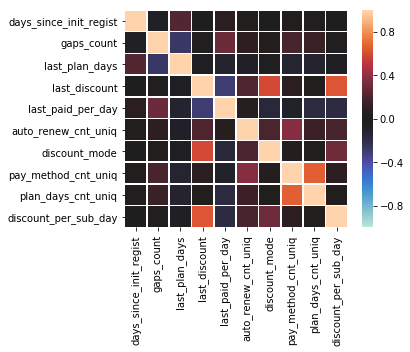

In [36]:
# plot selected
import matplotlib.pyplot as plt

corr_mat = get_corr_matrix(df0, fields_select_within_g0)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g0, ax)
fig.set_size_inches(5,4)
plt.show()

## group 1 ~ 3

In [37]:
g = 1
ww = '1'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 2, 3, 4, 10, 11, 12, 14})

In [38]:
list(enumerate(col_groups[g]))

[(0, 'last1WeekOnLine'),
 (1, 'w1_M25'),
 (2, 'w1_M50'),
 (3, 'w1_M75'),
 (4, 'w1_M985'),
 (5, 'w1_M100'),
 (6, 'w1_Munq'),
 (7, 'w1_Msecs'),
 (8, 'w1_Mtotal'),
 (9, 'w1_M25_D_Mtotal'),
 (10, 'w1_M50_D_Mtotal'),
 (11, 'w1_M75_D_Mtotal'),
 (12, 'w1_M985_D_Mtotal'),
 (13, 'w1_M100_D_Mtotal'),
 (14, 'w1_Munq_D_Mtotal'),
 (15, 'w1_M25M50M75_D_Mtotal'),
 (16, 'w1_M985M100_D_Mtotal'),
 (17, 'w1_M25M50_D_Mtotal')]

In [42]:
# add field here:
fields_select_within_g1 = [col_groups[g][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g1

['last1WeekOnLine',
 'w1_M25',
 'w1_M75',
 'w1_M985',
 'w1_Mtotal',
 'w1_M50_D_Mtotal',
 'w1_M75_D_Mtotal',
 'w1_M985_D_Mtotal',
 'w1_M100_D_Mtotal',
 'w1_Munq_D_Mtotal']

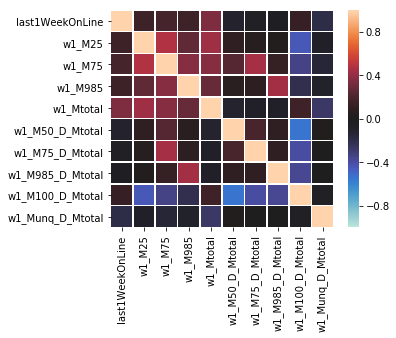

In [43]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g1)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g1, ax)
fig.set_size_inches(5,4)
plt.show()

In [44]:
g = 2
ww = '2'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 2, 3, 4, 10, 11, 12, 14})

In [49]:
# add field here:
fields_select_within_g2 = [col_groups[2][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g2

['last2WeekOnLine',
 'w2_M25',
 'w2_M75',
 'w2_M985',
 'w2_Mtotal',
 'w2_M50_D_Mtotal',
 'w2_M75_D_Mtotal',
 'w2_M985_D_Mtotal',
 'w2_M100_D_Mtotal',
 'w2_Munq_D_Mtotal']

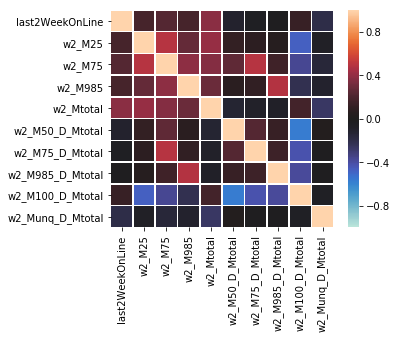

In [50]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g2)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g2, ax)
fig.set_size_inches(5,4)
plt.show()

In [51]:
g = 3
ww = '4'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 2, 3, 4, 10, 11, 12, 14})

In [52]:
# add field here:
fields_select_within_g3 = [col_groups[3][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g3

['last4WeekOnLine',
 'w4_M25',
 'w4_M75',
 'w4_M985',
 'w4_Mtotal',
 'w4_M50_D_Mtotal',
 'w4_M75_D_Mtotal',
 'w4_M985_D_Mtotal',
 'w4_M100_D_Mtotal',
 'w4_Munq_D_Mtotal']

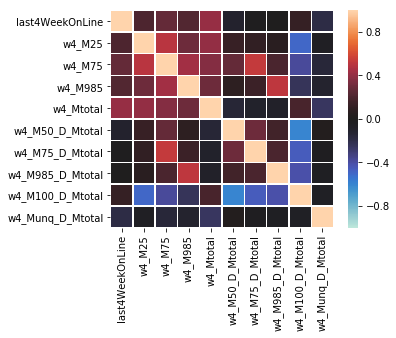

In [53]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g3)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g3, ax)
fig.set_size_inches(5,4)
plt.show()

## group 4

In [58]:
g = 4
ww = '6'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{2, 3},
  {5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{2, 3}, {5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 4, 10, 11, 12, 14})

In [60]:
# add field here:
fields_select_within_g4 = [col_groups[4][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g4

['last6WeekOnLine',
 'w6_M25',
 'w6_M75',
 'w6_M985',
 'w6_Mtotal',
 'w6_M50_D_Mtotal',
 'w6_M75_D_Mtotal',
 'w6_M985_D_Mtotal',
 'w6_M100_D_Mtotal',
 'w6_Munq_D_Mtotal']

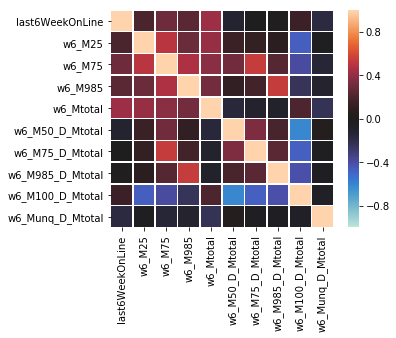

In [61]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g4)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g4, ax)
fig.set_size_inches(5,4)
plt.show()

## group 5

In [62]:
g = 5
ww = '9'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{2, 3},
  {5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{2, 3}, {5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 4, 10, 11, 12, 14})

In [63]:
# add field here:
fields_select_within_g5 = [col_groups[5][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g5

['last9WeekOnLine',
 'w9_M25',
 'w9_M75',
 'w9_M985',
 'w9_Mtotal',
 'w9_M50_D_Mtotal',
 'w9_M75_D_Mtotal',
 'w9_M985_D_Mtotal',
 'w9_M100_D_Mtotal',
 'w9_Munq_D_Mtotal']

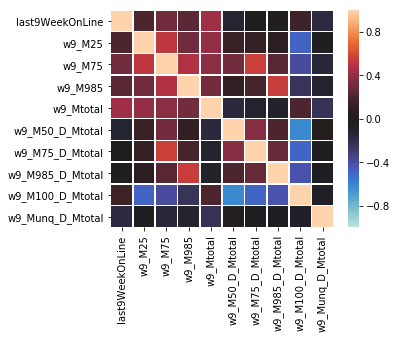

In [64]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g5)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g5, ax)
fig.set_size_inches(5,4)
plt.show()

## group 6

In [65]:
g = 6
ww = '12'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

([{2, 3},
  {5, 6},
  {5, 7},
  {6, 7},
  {5, 8},
  {6, 8},
  {7, 8},
  {9, 13},
  {9, 15},
  {13, 15},
  {9, 16},
  {13, 16},
  {15, 16},
  {9, 17},
  {13, 17},
  {15, 17},
  {16, 17}],
 [{2, 3}, {5, 6, 7, 8}, {9, 13, 15, 16, 17}],
 {0, 1, 4, 10, 11, 12, 14})

In [66]:
# add field here:
fields_select_within_g6 = [col_groups[6][i] for i in [0, 1, 3, 4, 8, 10, 11, 12, 13, 14]]
fields_select_within_g6

['last12WeekOnLine',
 'w12_M25',
 'w12_M75',
 'w12_M985',
 'w12_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal']

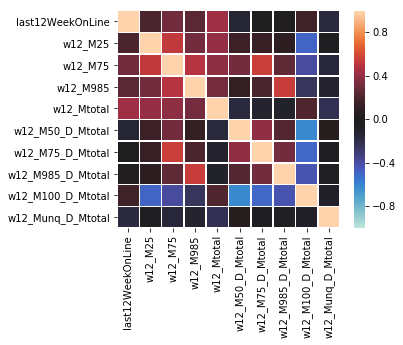

In [67]:
# plot selected
corr_mat = get_corr_matrix(df, fields_select_within_g6)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_select_within_g6, ax)
fig.set_size_inches(5,4)
plt.show()

# final field-selection

In [68]:
field_groups = [
    fields_select_within_g0, 
    fields_select_within_g1, 
    fields_select_within_g2, 
    fields_select_within_g3, 
    fields_select_within_g4, 
    fields_select_within_g5, 
    fields_select_within_g6
]

In [69]:
field_groups

[['days_since_init_regist',
  'gaps_count',
  'last_plan_days',
  'last_discount',
  'last_paid_per_day',
  'auto_renew_cnt_uniq',
  'discount_mode',
  'pay_method_cnt_uniq',
  'plan_days_cnt_uniq',
  'discount_per_sub_day'],
 ['last1WeekOnLine',
  'w1_M25',
  'w1_M75',
  'w1_M985',
  'w1_Mtotal',
  'w1_M50_D_Mtotal',
  'w1_M75_D_Mtotal',
  'w1_M985_D_Mtotal',
  'w1_M100_D_Mtotal',
  'w1_Munq_D_Mtotal'],
 ['last2WeekOnLine',
  'w2_M25',
  'w2_M75',
  'w2_M985',
  'w2_Mtotal',
  'w2_M50_D_Mtotal',
  'w2_M75_D_Mtotal',
  'w2_M985_D_Mtotal',
  'w2_M100_D_Mtotal',
  'w2_Munq_D_Mtotal'],
 ['last4WeekOnLine',
  'w4_M25',
  'w4_M75',
  'w4_M985',
  'w4_Mtotal',
  'w4_M50_D_Mtotal',
  'w4_M75_D_Mtotal',
  'w4_M985_D_Mtotal',
  'w4_M100_D_Mtotal',
  'w4_Munq_D_Mtotal'],
 ['last6WeekOnLine',
  'w6_M25',
  'w6_M75',
  'w6_M985',
  'w6_Mtotal',
  'w6_M50_D_Mtotal',
  'w6_M75_D_Mtotal',
  'w6_M985_D_Mtotal',
  'w6_M100_D_Mtotal',
  'w6_Munq_D_Mtotal'],
 ['last9WeekOnLine',
  'w9_M25',
  'w9_M75',
 

## wXX_Mtotal > 0

In [71]:
df = df0.where('w1_Mtotal > 0').where('w2_Mtotal > 0').where('w4_Mtotal > 0') \
    .where('w6_Mtotal > 0').where('w9_Mtotal > 0').where('w12_Mtotal > 0')
cols_all_groups = [c  for g in field_groups[:7]  for c in g]

corr_mat = get_corr_matrix(df, cols_all_groups)
find_correlated_field_groups(corr_mat, cols_all_groups, corr_abs_threshold)

([{10, 20},
  {11, 21},
  {12, 22},
  {13, 23},
  {14, 24},
  {15, 25},
  {18, 28},
  {19, 29},
  {10, 30},
  {20, 30},
  {11, 31},
  {21, 31},
  {22, 32},
  {13, 33},
  {23, 33},
  {14, 34},
  {24, 34},
  {25, 35},
  {27, 37},
  {18, 38},
  {28, 38},
  {19, 39},
  {29, 39},
  {10, 40},
  {20, 40},
  {30, 40},
  {11, 41},
  {21, 41},
  {31, 41},
  {22, 42},
  {32, 42},
  {13, 43},
  {23, 43},
  {33, 43},
  {14, 44},
  {24, 44},
  {34, 44},
  {35, 45},
  {36, 46},
  {37, 47},
  {28, 48},
  {38, 48},
  {29, 49},
  {39, 49},
  {10, 50},
  {20, 50},
  {30, 50},
  {40, 50},
  {21, 51},
  {31, 51},
  {41, 51},
  {32, 52},
  {42, 52},
  {13, 53},
  {23, 53},
  {33, 53},
  {43, 53},
  {14, 54},
  {24, 54},
  {34, 54},
  {44, 54},
  {35, 55},
  {45, 55},
  {46, 56},
  {37, 57},
  {47, 57},
  {28, 58},
  {38, 58},
  {48, 58},
  {29, 59},
  {39, 59},
  {49, 59},
  {10, 60},
  {20, 60},
  {30, 60},
  {40, 60},
  {50, 60},
  {21, 61},
  {31, 61},
  {41, 61},
  {51, 61},
  {32, 62},
  {42, 62},
  {5

In [72]:
# selected fields:
fields_selected = [cols_all_groups[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                                                16, 17, 26,
                                                30, 31, 32, 33, 34, 35, 38, 39, 37, 36]]
fields_selected

['days_since_init_regist',
 'gaps_count',
 'last_plan_days',
 'last_discount',
 'last_paid_per_day',
 'auto_renew_cnt_uniq',
 'discount_mode',
 'pay_method_cnt_uniq',
 'plan_days_cnt_uniq',
 'discount_per_sub_day',
 'w1_M75_D_Mtotal',
 'w1_M985_D_Mtotal',
 'w2_M75_D_Mtotal',
 'last4WeekOnLine',
 'w4_M25',
 'w4_M75',
 'w4_M985',
 'w4_Mtotal',
 'w4_M50_D_Mtotal',
 'w4_M100_D_Mtotal',
 'w4_Munq_D_Mtotal',
 'w4_M985_D_Mtotal',
 'w4_M75_D_Mtotal']

In [74]:
len(fields_selected)

23

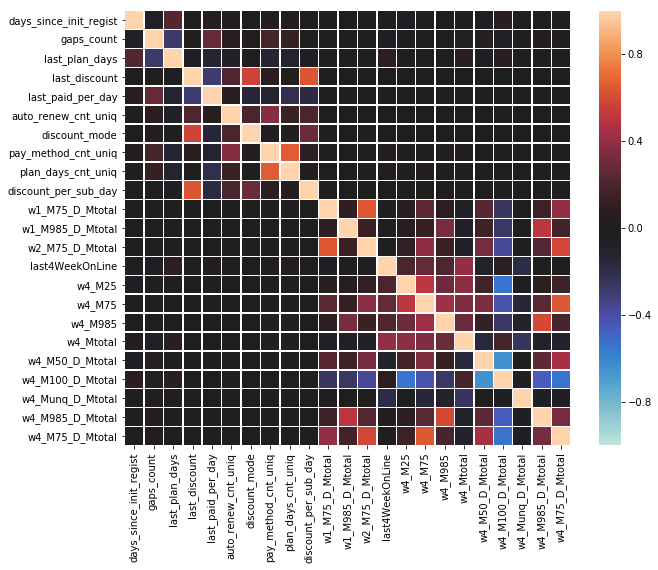

In [75]:
import matplotlib.pyplot as plt

corr_mat = get_corr_matrix(df, fields_selected)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_selected, ax)
fig.set_size_inches(10,8)
plt.show()

# corr. matrix of final selected fields:

# actual select and output

In [77]:
# read file
dir0 =  '/home/cloudera/2.kkbox_churn/data01/big_table_01/has_expired/'
# infile = dir0 + '19a.train_set'
infile = dir0 + '19b.test_set'

df = spark.read.format('parquet').load(infile)

# select field
df = df.select(categ_cols+fields_selected)

# output
# outfile = dir0 + '20a.train.field-select_correlation-0.7'
outfile = dir0 + '20b.test.field-select_correlation-0.7'
df.write.format('parquet').save(outfile)